In [16]:
import tensorflow as tf
import os
import cv2, imghdr
import numpy as np
from matplotlib import pyplot as plt

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

# 2 Preprocess Data

2.1 Remove dodgy immages
1. Check if the image is in a valid format
2. thare is not tny problem with opening\loading the image

In [ ]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png'] # image extensions to be used for training

In [ ]:
for image_class in os.listdir(data_dir):
    print(image_class)

In [ ]:
for image_class in os.listdir(data_dir):  # Happy & Sad
    for image in os.listdir(os.path.join(data_dir, image_class)): # Each image in the class
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}")

2.2 Load Data into Dataset

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data') # Its make our data to immutable formate


In [ ]:
data_iterator = data.as_numpy_iterator() 

In [ ]:
batch = data_iterator.next() # Get the first batch

In [ ]:
batch[0].shape # (32, 256, 256, 3) 32 images, 256x256 pixels, 3 color channels the images as numpy arrays 
batch[1] # (32,) 32 labels

In [ ]:
fig, ax = plt.subplots(ncols = 5, figsize = (20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

2.3 Scale Data for better performence

In [ ]:
scaled_data = data.map(lambda x, y: (x/255.0, y)) # Normalize the images to [0,1] range


In [ ]:
scaled_iterator = scaled_data.as_numpy_iterator()


In [ ]:
# Get the next batch
scaled_batch = scaled_iterator.next()

In [ ]:
# Plot the images and labels from the batch when the data is scaled
fig, ax = plt.subplots(ncols = 5, figsize = (20,20))
for idx, img in enumerate(scaled_batch[0][:5]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.4 Split The Data

In [ ]:
# Split the data into training test and validation sets
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 3 Deep Modelling

3.1 Build Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential # One input and one output 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
model = Sequential()

In [ ]:
#                input filters, , pixel size, relu - to remove negative values
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D()) # Take the max value from the 2x2 matrix in filter of 3x3

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D()) # Take the max value from the 2x2 matrix

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D()) # Take the max value from the 2x2 matrix

model.add(Flatten()) # Flatten the 3D array to 1D array in order to feed it to the fully connected layer
                # output, kinf of activation function 
model.add(Dense(256, activation = 'relu')) # fully connected layer
model.add(Dense(1, activation = 'sigmoid')) # output layer sigmoid - to get the probability between 0 and 1 - 0 - sad, 1 - happy

In [ ]:
model.compile(optimizer = 'adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])
# adam - adaptive moment estimation - to find the best learning rate, loss - to calculate the loss, metrics - to calculate the accuracy

In [ ]:
model.summary()


3.2 Train The Model

In [ ]:
logdir = 'lods'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback]) # train the model and save the history

In [ ]:
hist.history['loss'][0] = 2.3999

3.3 Plot Preformance

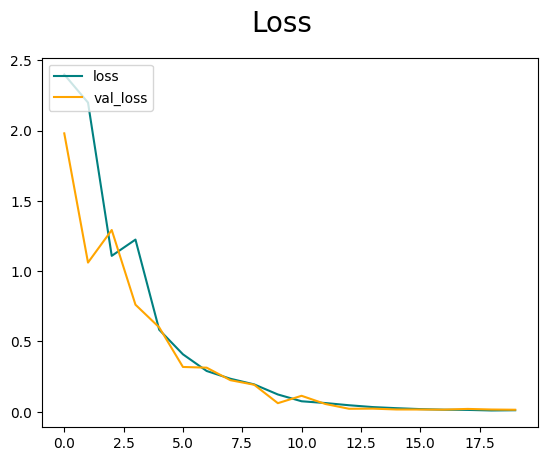

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

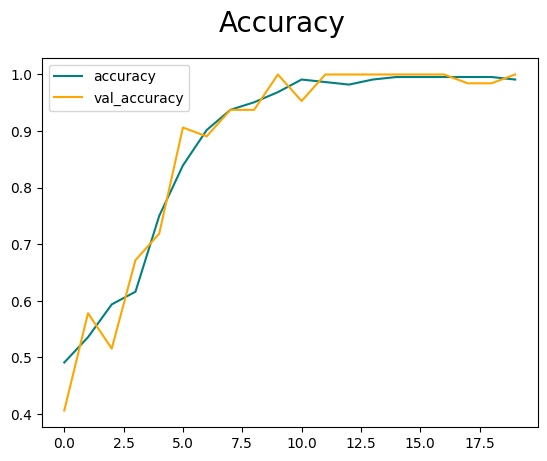

In [33]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# 4 Evaluate Preformance

In [36]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
model_prec = Precision()
re_call = Recall()
model_accu = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator():
    x, y = batch
    y_pred = model.predict(x)
    model_prec.update_state(y, y_pred)
    re_call.update_state(y, y_pred)
    model_accu.update_state(y, y_pred)

In [50]:
print(f"Precision: {model_prec.result().numpy()}, Recall: {re_call.result().numpy()}, Accuracy: {model_accu.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


# 5 Save The Model

In [51]:
from tensorflow.keras.models import load_model

In [52]:
model.save(os.path.join('models', 'happy_sad_model.h5'))

In [53]:
new_model = load_model(os.path.join('models', 'happy_sad_model.h5'))

In [54]:
new_model